<a href="https://colab.research.google.com/github/corrine1106/Project_EDA/blob/master/item2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 

# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

# !!!!後續在相關函式中增加fontproperties=myfont屬性即可!!!!

--2022-01-04 06:10:29--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.216.139, 173.194.216.102, 173.194.216.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3351obs8onirevmp04kdegtqqbkbt780/1641276600000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2022-01-04 06:10:33--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3351obs8onirevmp04kdegtqqbkbt780/1641276600000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.216.132, 2607:f8b0:400c:c12::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|1

# Load data

In [42]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format',lambda x:'%.0f'%x)

data = pd.read_csv('/content/drive/MyDrive/T大使/data3_project (1).csv')

In [43]:
data = data.loc[~ data.CustomerID.isnull()]

In [44]:
data.isnull().any()

InvoiceNo            False
StockCode            False
Description          False
Quantity             False
InvoiceDate          False
UnitPrice            False
CustomerID           False
Country              False
member_start_date     True
first_trans_date      True
dtype: bool

In [45]:
df_group = data.groupby('CustomerID')['Description'].apply(lambda x: ' '.join([str(m) for m in x])).reset_index()

In [46]:
df_group.to_csv('/content/drive/MyDrive/T大使/itemlens_uid_itemids.csv', index=False)

# Use Pyspark train item2vec

In [47]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!pip install pyspark
!pip install findspark

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jre-headless_8u292-b10-0ubuntu1~18.04_amd64.deb  404  Not Found [IP: 91.189.88.142 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jdk-headless_8u292-b10-0ubuntu1~18.04_amd64.deb  404  Not Found [IP: 91.189.88.142 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [48]:
import findspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PySpark Item2vec').getOrCreate()
sc = spark.sparkContext

In [49]:
df = spark.read.csv('/content/drive/MyDrive/T大使/itemlens_uid_itemids.csv',header=True)
df.show(5)

+---------------+------------------------------------+
|     CustomerID|                         Description|
+---------------+------------------------------------+
|9100000000061.0|        24H賦活液100ml 玫瑰晶萃瞬...|
|9100000000085.0|五日激光煥顏課程單堂 膠原晶球水導...|
|9100000000092.0|       超導水網瞬效面膜26ml*6包 2...|
|9100000000115.0|        玫瑰晶萃水面膜10ml*10支 D...|
|9100000000170.0|     旗艦全背順氣活力SPA課程2.0單...|
+---------------+------------------------------------+
only showing top 5 rows



In [50]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

df = df.withColumn('Description',F.split(df.Description," "))

## train model

In [51]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(vectorSize=5,minCount=0,inputCol='Description',outputCol='Stock2vec')

model = word2Vec.fit(df)

In [52]:
model.getVectors().show(3,truncate=False)

+------------------------------+----------------------------------------------------------------------------------------------------------+
|word                          |vector                                                                                                    |
+------------------------------+----------------------------------------------------------------------------------------------------------+
|激活更新護理_臉部溫灸單堂     |[0.916215181350708,1.1725693941116333,-0.24337930977344513,-0.012782944366335869,1.0096768140792847]      |
|2017MOMO購物網背部舒壓樂活課程|[-0.006564527750015259,0.02948511764407158,-0.05063652992248535,0.05798725783824921,-0.024534352123737335]|
|(3.0                          |[0.45537877082824707,0.9468466639518738,1.6765223741531372,0.02337840385735035,-0.47077998518943787]      |
+------------------------------+----------------------------------------------------------------------------------------------------------+
only showing top 3 rows



/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [53]:
model.getVectors().select("word","vector").toPandas().to_csv('/content/drive/MyDrive/T大使/item2vec.csv',index=False)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


# TSNE

In [54]:
word = model.getVectors().select("word")
word = np.array(word.select('word').collect())
word = word.reshape(-1)

item_v = model.getVectors().select("vector")
item_v = np.array(item_v.select('vector').collect())

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [56]:
item_v = item_v.reshape(item_v.shape[0],-1)

In [58]:
from sklearn import manifold

X_tsne = manifold.TSNE(n_components=2,init='random',random_state=5,verbose=1).fit_transform(item_v)

x_min, x_max = X_tsne.min(0),X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 866 samples in 0.002s...
[t-SNE] Computed neighbors for 866 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 866 / 866
[t-SNE] Mean sigma: 0.130851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.431095
[t-SNE] KL divergence after 1000 iterations: 0.663188


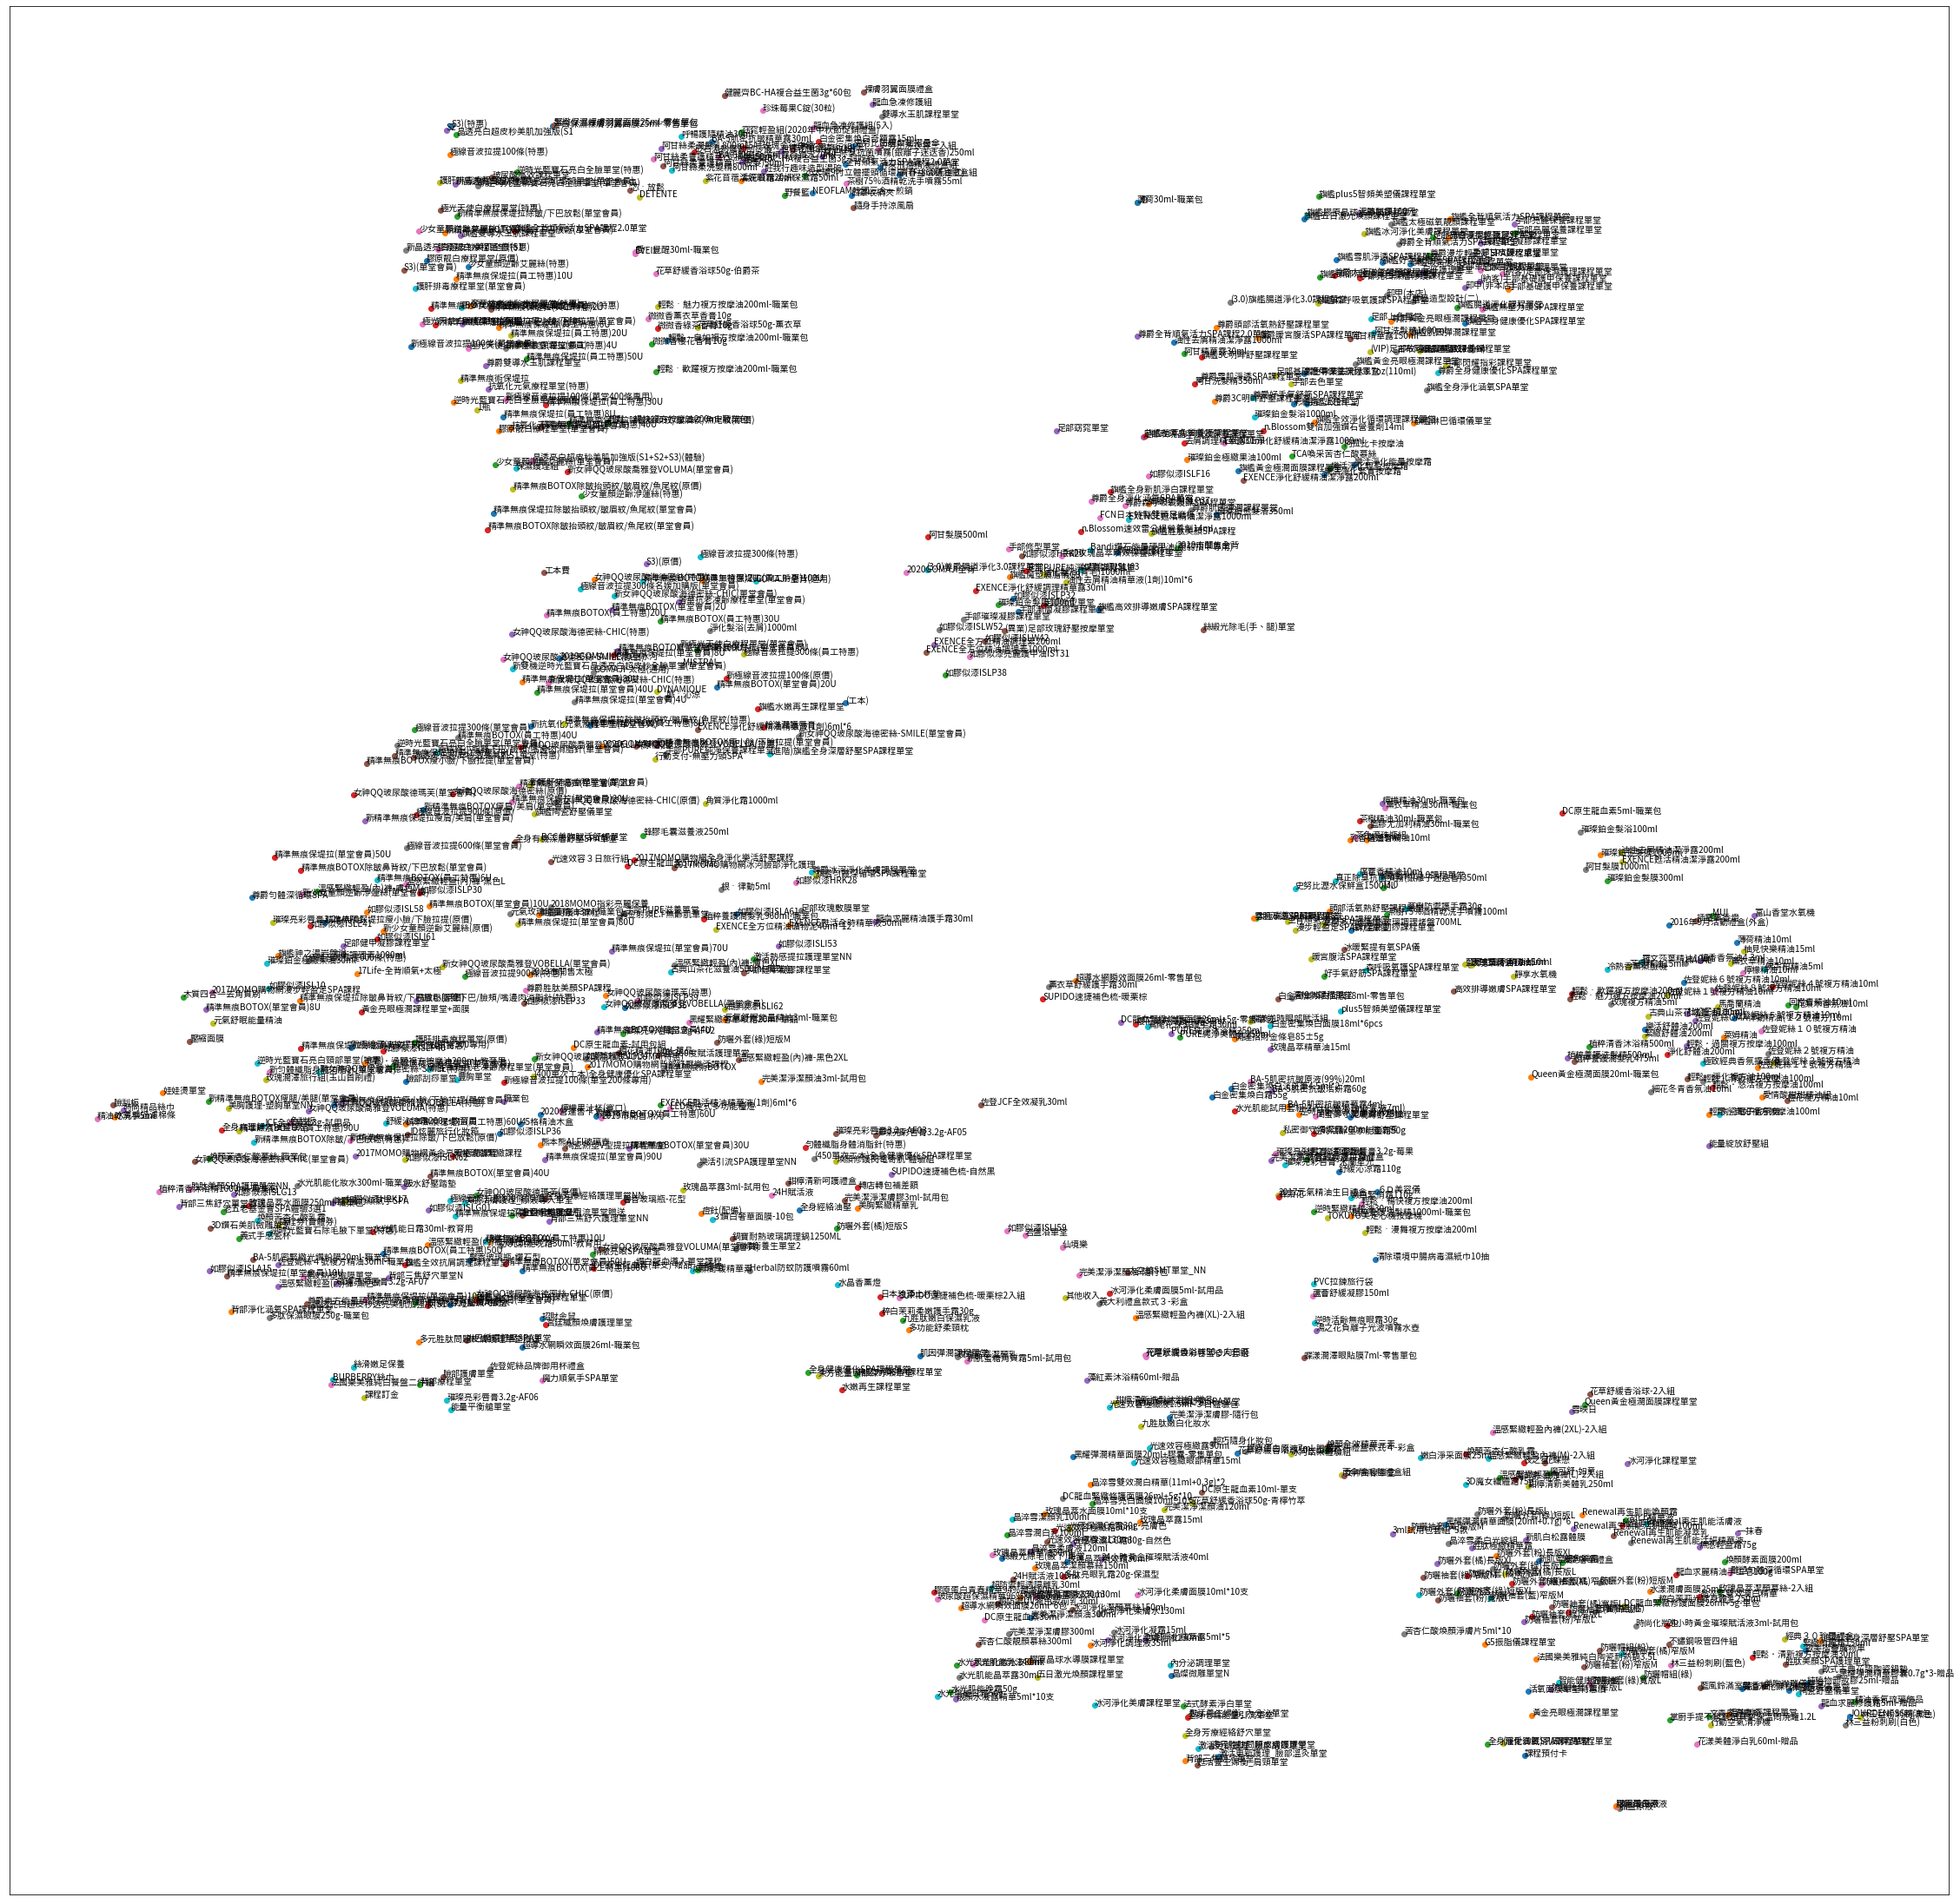

In [65]:
fig, ax = plt.subplots(figsize=(40, 40))
for i in range(X_norm.shape[0]):
    ax.scatter(X_norm[i, 0], X_norm[i, 1])
    ax.annotate(word[i],(X_norm[i, 0], X_norm[i, 1]),fontproperties=myfont)
plt.xticks([])
plt.yticks([])
plt.show()